# Prescriptor robojudge
Notebook for evaluating prescriptions using standard predictor.

The main metric computed is based on how many other prescriptions
each submission dominates on the pareto front of stringency vs cases.

In [1]:
import os
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd

from helpers.utils import IP_COLS as NPI_COLUMNS, _dot
from helpers.prescriptor_scoring import weight_prescriptions_by_cost
from helpers.prescriptor_scoring import generate_cases_and_stringency_for_prescriptions
from helpers.prescriptor_scoring import compute_domination_df
from helpers.prescriptor_scoring import compute_pareto_set
from helpers.prescriptor_validation import validate_submission

In [2]:
# Can set these longer for better evaluation. Will increase eval time
START_DATE = "2020-08-01"
END_DATE = "2020-08-05"

# Prepare Historical IP Data

In [3]:
from helpers.predictor_scoring import load_dataset
from helpers.scenario_generator import generate_scenario

LATEST_DATA_URL = '../../data/oxford/country/AL-estimate.csv'
GEO_FILE = "countries_regions.csv"

latest_df = load_dataset(LATEST_DATA_URL, GEO_FILE)

In [4]:
IP_FILE = "prescriptions/robojudge_test_scenario.csv"
countries = ["Albania"]
scenario_df = generate_scenario(START_DATE, END_DATE, latest_df, countries, scenario="Freeze")
scenario_df.to_csv(IP_FILE, index=False)

# Generate some prescriptions

In [5]:
# Cost weightings for each IP for each geo
TEST_COST = "../validation/data/uniform_random_costs_.csv"

In [6]:
# Generate some random prescriptions
for i in range(2):
    output_file = "./examples/prescriptors/random/prescriptions/random_presc_"+ str(i+1) +".csv"
    !python ./examples/prescriptors/random/prescribe.py -s {START_DATE} \
                                                                   -e {END_DATE} \
                                                                   -ip {IP_FILE} \
                                                                   -c {TEST_COST} \
                                                                   -o {output_file}

Generating prescriptions from 2020-08-01 to 2020-08-05...
Done!
Generating prescriptions from 2020-08-01 to 2020-08-05...
Done!


In [7]:
# Generate blind_greedy prescriptions
output_file = "./examples/prescriptors/blind_greedy/prescriptions/blind_greedy.csv"
!python ./examples/prescriptors/blind_greedy/prescribe.py -s {START_DATE} \
                                                                     -e {END_DATE} \
                                                                     -ip {IP_FILE} \
                                                                     -c {TEST_COST} \
                                                                     -o {output_file}

Generating prescriptions from 2020-08-01 to 2020-08-05...
Done!


In [6]:
prescription_files = {
#     'NeatExample': './neat_prescriptions_example.csv',
    'Random1': './examples/prescriptors/random/prescriptions/random_presc_1.csv',
    'Random2': './examples/prescriptors/random/prescriptions/random_presc_2.csv',
    'BlindGreedy': './examples/prescriptors/blind_greedy/prescriptions/blind_greedy.csv',
    'ours': './prescriptions/ours3.csv',
}

In [7]:
# Validate the prescription files
for prescriptor_name, output_file in prescription_files.items():
    errors = validate_submission(START_DATE, END_DATE, IP_FILE, output_file)
    if errors:
        for error in errors:
            print(f"{prescriptor_name}: {error}")
    else:
        print(f"{prescriptor_name}: All good!")

Random1: All good!
Random2: All good!
BlindGreedy: All good!
ours: All good!


# Evaluate them

In [137]:
# Collect case and stringency data for all prescriptors
dfs = []
for prescriptor_name, prescription_file in sorted(prescription_files.items()):
    print("Generating predictions for", prescriptor_name)
    df, _ = generate_cases_and_stringency_for_prescriptions(START_DATE, END_DATE, prescription_file, TEST_COST)
    df['PrescriptorName'] = prescriptor_name
    dfs.append(df)
df = pd.concat(dfs)

Generating predictions for BlindGreedy
Generated predictions for PrescriptionIndex 0
Generated predictions for PrescriptionIndex 1
Generated predictions for PrescriptionIndex 2
Generated predictions for PrescriptionIndex 3
Generated predictions for PrescriptionIndex 4
Generated predictions for PrescriptionIndex 5
Generated predictions for PrescriptionIndex 6
Generated predictions for PrescriptionIndex 7
Generated predictions for PrescriptionIndex 8
Generated predictions for PrescriptionIndex 9
Evaluated 10 PrescriptionIndex in 00:00:11 seconds
Generating predictions for Random1
Generated predictions for PrescriptionIndex 0
Generated predictions for PrescriptionIndex 1
Generated predictions for PrescriptionIndex 2
Generated predictions for PrescriptionIndex 3
Generated predictions for PrescriptionIndex 4
Generated predictions for PrescriptionIndex 5
Generated predictions for PrescriptionIndex 6
Generated predictions for PrescriptionIndex 7
Generated predictions for PrescriptionIndex 8
G

In [138]:
df[df['CountryName'] == 'Albania']

,CountryName,RegionName,PrescriptionIndex,PredictedDailyNewCases,Stringency,PrescriptorName
0,Albania,NaN,0,159.595682,0.200,BlindGreedy
1,Albania,NaN,1,156.905153,0.400,BlindGreedy
2,Albania,NaN,2,153.994143,0.800,BlindGreedy
3,Albania,NaN,3,149.274740,1.220,BlindGreedy
4,Albania,NaN,4,148.664001,2.200,BlindGreedy
5,Albania,NaN,5,143.337473,6.520,BlindGreedy
6,Albania,NaN,6,142.619960,10.840,BlindGreedy
7,Albania,NaN,7,142.100050,13.720,BlindGreedy
8,Albania,NaN,8,141.556780,16.920,BlindGreedy
9,Albania,NaN,9,140.716189,21.780,BlindGreedy


In [139]:
ddf = compute_domination_df(df)

Computing domination for Albania nan


In [140]:
# Get number of dominated prescriptions for each submission. This is the "Domination Count"
ddf.groupby('DominatingName').count().sort_values('DominatedIndex', ascending=False)['DominatedIndex']

DominatingName
BlindGreedy    20
ours           20
Random2         7
Random1         5
Name: DominatedIndex, dtype: int64

In [141]:
def plot_pareto_curve(objective1_list, objective2_list):
    """
    Plot the pareto curve given the objective values for a set of solutions.
    This curve indicates the area dominated by the solution set, i.e., 
    every point up and to the right is dominated.
    """
    
    # Compute pareto set from full solution set.
    objective1_pareto, objective2_pareto = compute_pareto_set(objective1_list, 
                                                              objective2_list)
    
    # Sort by first objective.
    objective1_pareto, objective2_pareto = list(zip(*sorted(zip(objective1_pareto,
                                                                objective2_pareto))))
    
    # Compute the coordinates to plot.
    xs = []
    ys = []
    
    xs.append(objective1_pareto[0])
    ys.append(objective2_pareto[0])
    
    for i in range(0, len(objective1_pareto)-1):
        
        # Add intermediate point between successive solutions
        xs.append(objective1_pareto[i+1])
        ys.append(objective2_pareto[i])
        
        # Add next solution on front
        xs.append(objective1_pareto[i+1])
        ys.append(objective2_pareto[i+1])
        
    plt.plot(xs, ys)

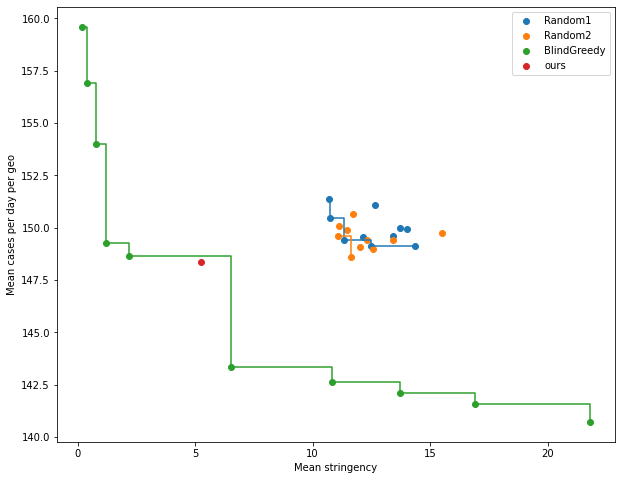

In [142]:
# Plot overall stringency and cases of each prescription
plt.figure(figsize=(10,8))
for prescriptor_name in prescription_files:
    pdf = df[df['PrescriptorName'] == prescriptor_name]
    overall_pdf = pdf.groupby('PrescriptionIndex').mean().reset_index()
    plt.scatter(overall_pdf['Stringency'],
                overall_pdf['PredictedDailyNewCases'], 
                label=prescriptor_name)
    plot_pareto_curve(list(overall_pdf['Stringency']),
                      list(overall_pdf['PredictedDailyNewCases']))
plt.xlabel('Mean stringency')
plt.ylabel('Mean cases per day per geo')
plt.legend()
plt.show()

<AxesSubplot:xlabel='Date', ylabel='Stringency'>

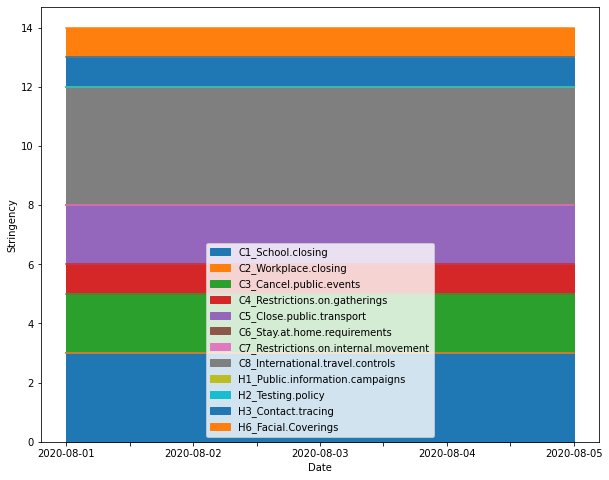

In [143]:
# Plot stacked line chart of npis over time for a prescription for a particular geo

#submission_file = 'covid_xprize.examples/prescriptors/neat/test_prescriptions/pres.csv'
submission_file = './prescriptions/ours3.csv'

prescription_index = 1
country_name = 'Albania'
region_name = None
NPI_COLUMNS = _dot(NPI_COLUMNS)

pdf = pd.read_csv(submission_file)
gdf = pdf[(pdf['PrescriptionIndex'] == prescription_index) &
          (pdf['CountryName'] == country_name) &
          (pdf['RegionName'].isna() if region_name is None else (pdf['RegionName'] == 'region_name'))]
gdf.plot.area(x='Date', y=NPI_COLUMNS, figsize=(10,8), ylabel='Stringency')

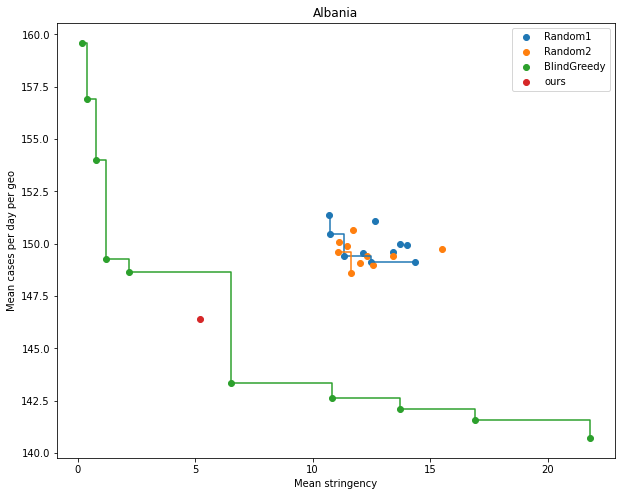

In [44]:
# Plot stringency and cases of each prescription for a particular country
country_name = 'Albania'
cdf = df[df.CountryName == country_name]

plt.figure(figsize=(10,8))
for prescriptor_name in prescription_files:
    pdf = cdf[cdf['PrescriptorName'] == prescriptor_name]
    #overall_pdf = pdf.groupby('PrescriptionIndex').mean().reset_index()
    plt.scatter(pdf['Stringency'],
                pdf['PredictedDailyNewCases'], 
                label=prescriptor_name)
    plot_pareto_curve(list(pdf['Stringency']),
                      list(pdf['PredictedDailyNewCases']))
plt.xlabel('Mean stringency')
plt.ylabel('Mean cases per day per geo')
plt.title(country_name)
plt.legend()
plt.show()